In [18]:
from tensorflow.keras.models import load_model
from glob import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.vae_model import vae_model
from src.lstm_mapper_model import mapper_model
#from src.lstm_mapper_model import lstm_mapper_model
from src.util import (
    seq_data, 
    load_sim_data,  
    compute_perm_deviation, 
    calculate_perm_error, 
    select_random_instances,
    plot_boxplot,
    mesh_plot_comparisons,
    plot_mesh_permarray,
    load_exp_data,
    plot_mesh
)
from pyeit import mesh
from keras import backend as K
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tqdm import tqdm
import pandas as pd
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Load Data

In [2]:
n_el = 32
from pyeit import mesh
mesh_obj = mesh.create(n_el, h0=0.05)

In [3]:
def load_and_concatenate_data(folder_paths, seq_data_function, n_seg=4):
    all_voltage_seq = []
    all_gamma_seq = []
    
    for folder in tqdm(folder_paths, desc="Processing folders"):
        voltage_sim, gamma_sim, _ = load_sim_data(folder) 
        voltage = (voltage_sim - np.mean(voltage_sim, axis=0)) / np.std(voltage_sim, axis=0)
        voltage = voltage.reshape(-1, 32, 32, 1)
        gamma = gamma_sim.reshape(-1, 2840, 1)
        voltage_seq, gamma_seq = seq_data_function(voltage, gamma, n_seg=n_seg)
        
        all_voltage_seq.append(voltage_seq)
        all_gamma_seq.append(gamma_seq)
        
    concatenated_voltage_seq = np.concatenate(all_voltage_seq, axis=0)
    concatenated_gamma_seq = np.concatenate(all_gamma_seq, axis=0)
    return concatenated_voltage_seq, concatenated_gamma_seq

folder_paths = ["data34", "data35", "data36", "data37", "data38", "data39"]
voltage_seq, gamma_seq = load_and_concatenate_data(folder_paths, seq_data, n_seg=4)
print("Concatenated Voltages Shape:", voltage_seq.shape)
print("Concatenated Permittivity Shape:", gamma_seq.shape)

Processing folders: 100%|██████████| 6/6 [00:39<00:00,  6.62s/it]

Concatenated Voltages Shape: (14976, 4, 32, 32, 1)
Concatenated Permittivity Shape: (14976, 2840, 1)


## Loading VAE Model and generating labels

In [4]:
vae = vae_model()  
vae.build(input_shape=(None, 2840)) 
vae.load_weights("weights/vae2D_best_6000.weights.h5")
print("Gewichte erfolgreich geladen.")

_, _, latent_rep = vae.encoder.predict(gamma_seq)

Gewichte erfolgreich geladen.
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


## LSTM Mapper Training

In [5]:
(
    v_train_seq,
    v_test_seq,
    gamma_train,
    gamma_test,
    z_train,
    z_test,
) = train_test_split(
    voltage_seq,
    gamma_seq,
    latent_rep,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

In [6]:
lstm_mapper = mapper_model()
lstm_mapper.summary()
lstm_mapper.compile(optimizer="adam", loss="mse")

Model: "lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4, 32, 32, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 4, 15, 15, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 7, 7, 2)     │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 4, 98)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 4, 64)          │         6,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,082 (86.26 KB)

 Trainable params: 22,082 (86.26 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history_mapper = lstm_mapper.fit(v_train_seq, z_train, epochs=30, batch_size=8, validation_split = 0.1)

Epoch 1/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.5756 - val_loss: 0.2145
Epoch 2/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1977 - val_loss: 0.1770
Epoch 3/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1650 - val_loss: 0.1654
Epoch 4/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1501 - val_loss: 0.1569
Epoch 5/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1430 - val_loss: 0.1543
Epoch 6/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1361 - val_loss: 0.1534
Epoch 7/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1348 - val_loss: 0.1475
Epoch 8/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.1289 - val_loss: 0.1461
Epoch 9/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1253 - val_loss: 0.1465
Epoch 10/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1245 - val_loss: 0.1475
Epoch 11/30
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1220 - val_loss: 0.1443
Epoch 12/30
1517/1517 ━━━━━━

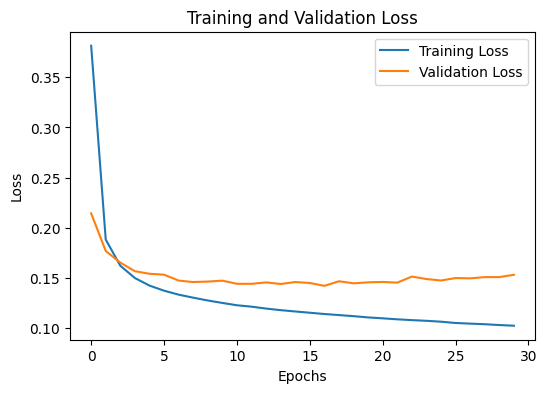

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(history_mapper.history["loss"], label="Training Loss")
plt.plot(history_mapper.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [9]:
weights_dir = "weights/"
os.makedirs(weights_dir, exist_ok=True)
lstm_weights_file = os.path.join(weights_dir, "lstm_circle_interpolation.weights.h5")
lstm_mapper.save_weights(lstm_weights_file)
print(f"Gewichte gespeichert unter: {lstm_weights_file}")

Gewichte gespeichert unter: weights/lstm_circle_interpolation.weights.h5


In [10]:
lstm_mapper.load_weights("weights/lstm_circle_interpolation.weights.h5")
print("Gewichte erfolgreich geladen.")

Gewichte erfolgreich geladen.


In [11]:
_, _, pred_latent = vae.encoder.predict(gamma_test)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)

pred_latent.shape, v_test_seq.shape, gamma_pred.shape

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


((1498, 8), (1498, 4, 32, 32, 1), (1498, 2840))

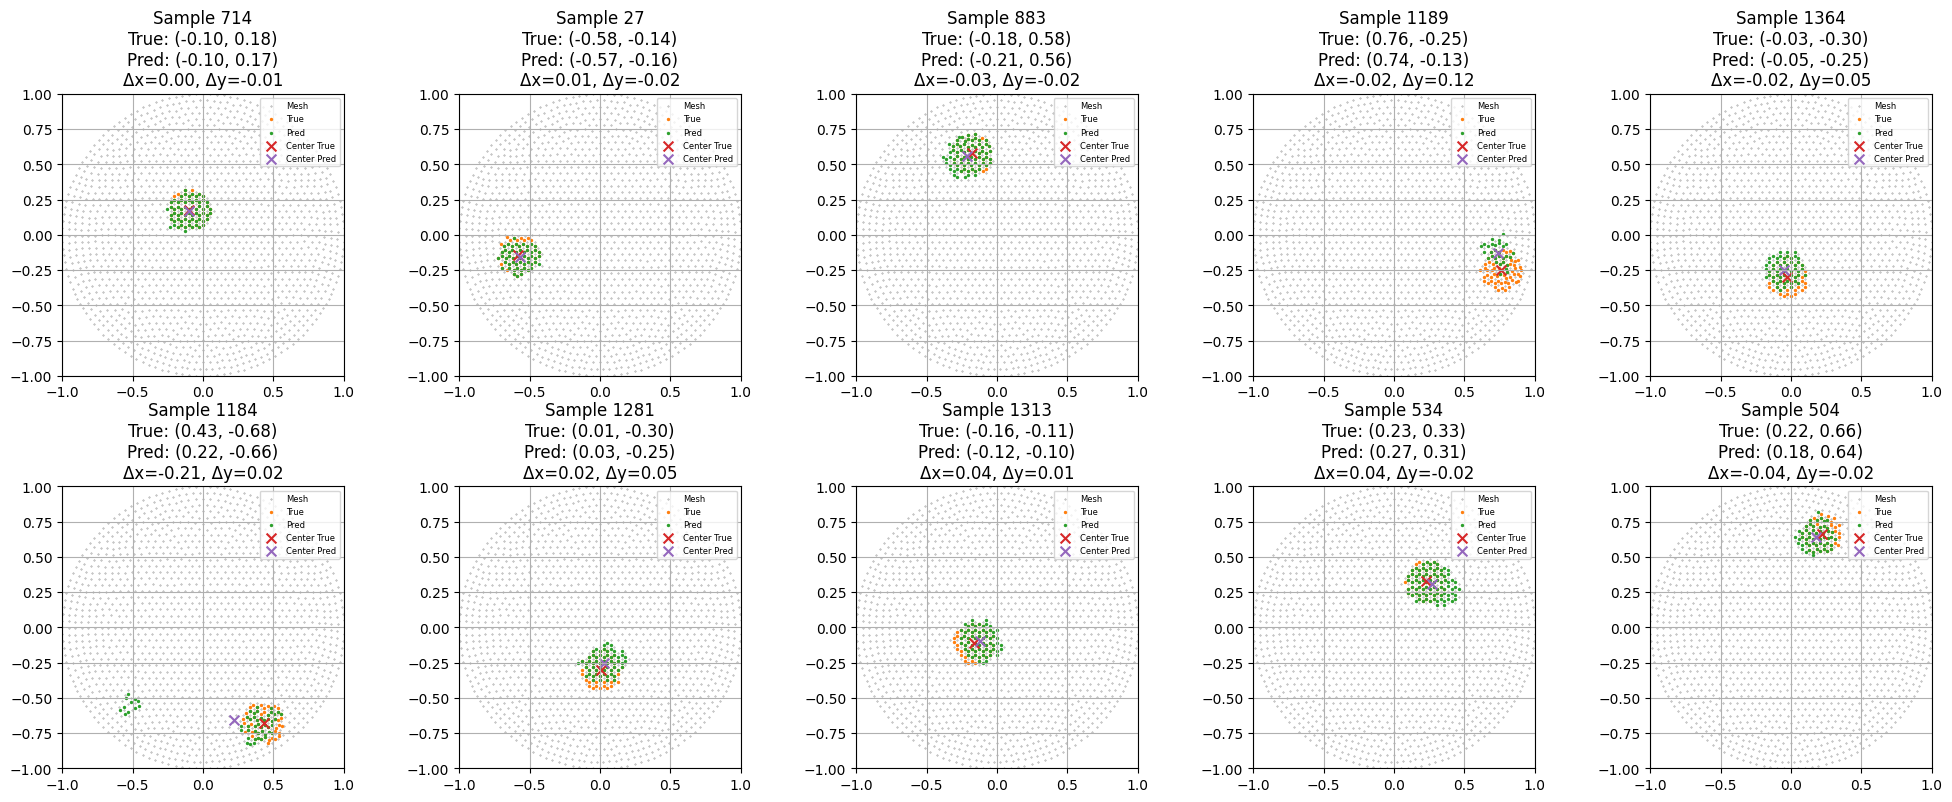

In [12]:
def compute_deviation(mesh_obj, true_perm, predicted_perm, threshhold=0.5):
    pts = mesh_obj.element
    tri = mesh_obj.node

    tri_centers = np.mean(tri[pts], axis=1)

    ixds_true = np.array(np.where(true_perm > threshhold)[0])
    koords_true = tri_centers[ixds_true]
    x_true = np.round(np.mean(koords_true[:, 0]), 2)
    y_true = np.round(np.mean(koords_true[:, 1]), 2)

    ixds_pred = np.array(np.where(predicted_perm > threshhold)[0])
    koords_pred = tri_centers[ixds_pred]
    x_pred = np.round(np.mean(koords_pred[:, 0]), 2)
    y_pred = np.round(np.mean(koords_pred[:, 1]), 2)

    deviation = (x_pred - x_true, y_pred - y_true)

    return deviation, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred


def plot_random_deviations(mesh_obj, true_perms, predicted_perms, num_samples=10, threshhold=0.5):
    random_indices = np.random.choice(len(true_perms), size=num_samples, replace=False)
    cols = 5
    rows = int(np.ceil(num_samples / cols))
    
    subplot_size = 4 
    fig, axes = plt.subplots(rows, cols, figsize=(cols * subplot_size, rows * subplot_size))
    axes = axes.flatten()
    
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        true_perm = true_perms[idx]
        predicted_perm = predicted_perms[idx]
        _, (x_true, y_true), (x_pred, y_pred), koords_true, koords_pred = compute_deviation(
            mesh_obj, true_perm, predicted_perm, threshhold=threshhold
        )
        
        ax.grid()
        ax.set_xlim((-1, 1))
        ax.set_ylim((-1, 1))
        ax.set_aspect('equal')
        
        ax.scatter(mesh_obj.node[:, 0], mesh_obj.node[:, 1], color="grey", s=0.1, label="Mesh")
        ax.scatter(koords_true[:, 0], koords_true[:, 1], color="C1", s=2, label="True")
        ax.scatter(koords_pred[:, 0], koords_pred[:, 1], color="C2", s=2, label="Pred")
        ax.scatter(x_true, y_true, marker="x", color="C3", s=50, label="Center True")
        ax.scatter(x_pred, y_pred, marker="x", color="C4", s=50, label="Center Pred")
        ax.set_title(f"Sample {idx}\nTrue: ({x_true:.2f}, {y_true:.2f})\nPred: ({x_pred:.2f}, {y_pred:.2f})\nΔx={x_pred-x_true:.2f}, Δy={y_pred-y_true:.2f}")
        ax.legend(fontsize=6)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_random_deviations(mesh_obj, gamma_test, gamma_pred, num_samples=10, threshhold=0.5)

## Load Test-Data

In [13]:
voltage_test_sim, gamma_test_sim , _ = load_sim_data("data40")
voltage_test_normalized = (voltage_test_sim - np.mean(voltage_test_sim, axis=0)) / np.std(voltage_test_sim, axis=0)
voltage_test = voltage_test_normalized.reshape(-1, 32, 32, 1)  
gamma_test = gamma_test_sim.reshape(-1, 2840, 1)

In [14]:
voltage_test_seq, gamma_test_seq = seq_data(voltage_test, gamma_test, n_seg=4)
voltage_test_seq.shape, gamma_test_seq.shape

((2496, 4, 32, 32, 1), (2496, 2840, 1))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/home/jy2353/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jy2353/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


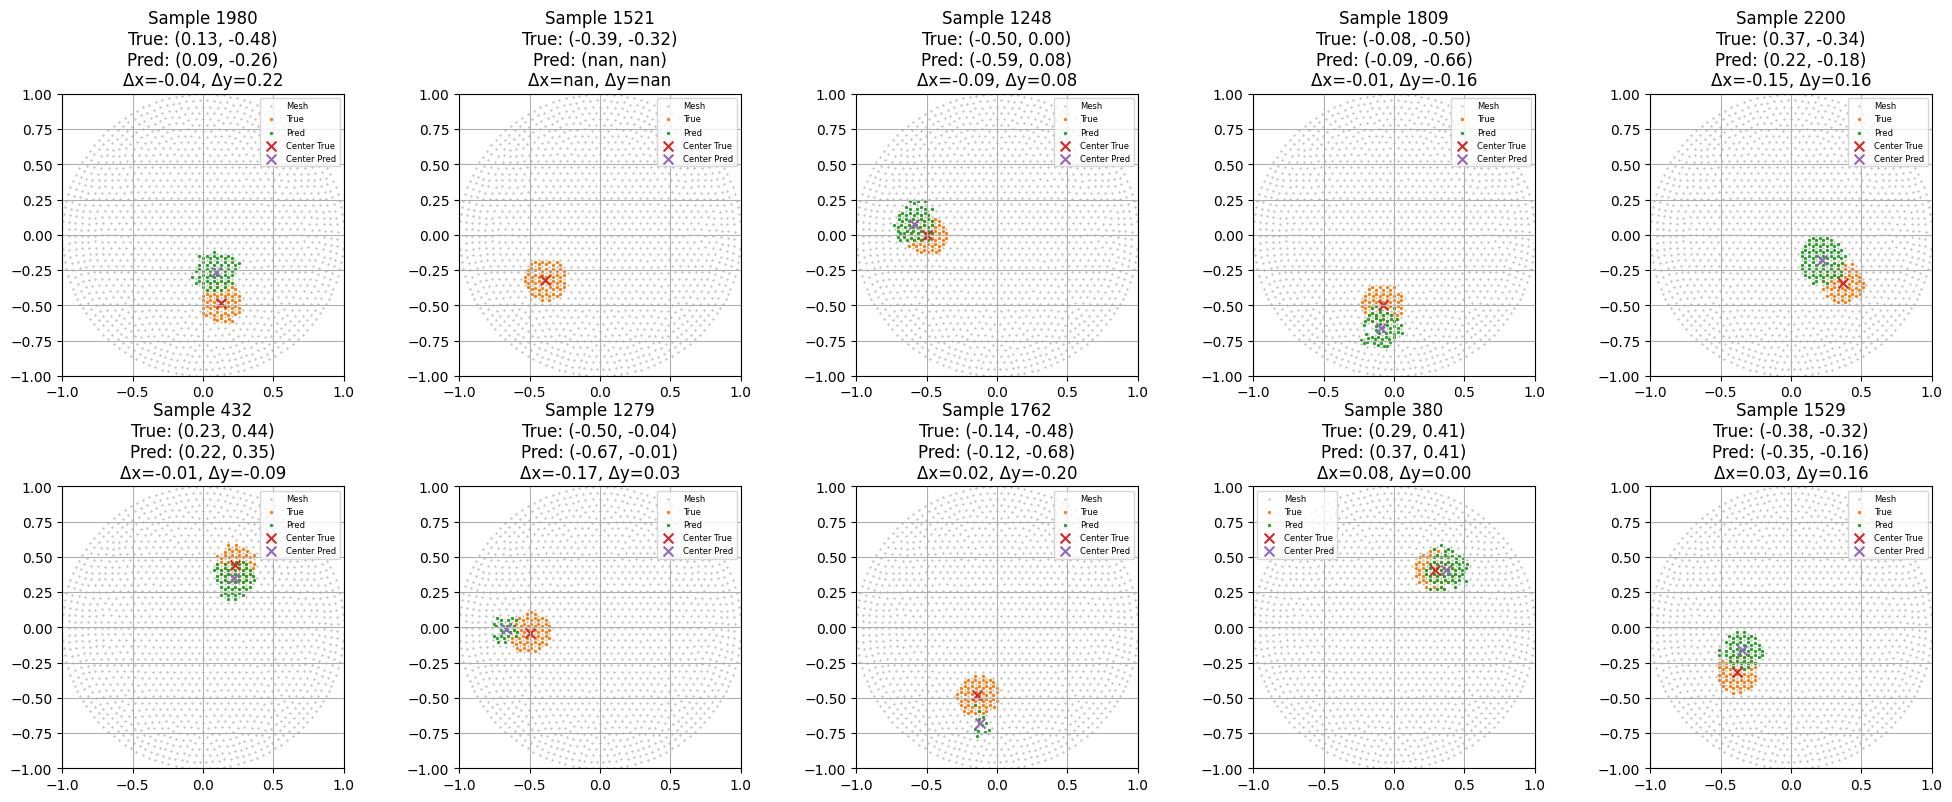

In [15]:
pred_latent = lstm_mapper.predict(voltage_test_seq)
gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840)


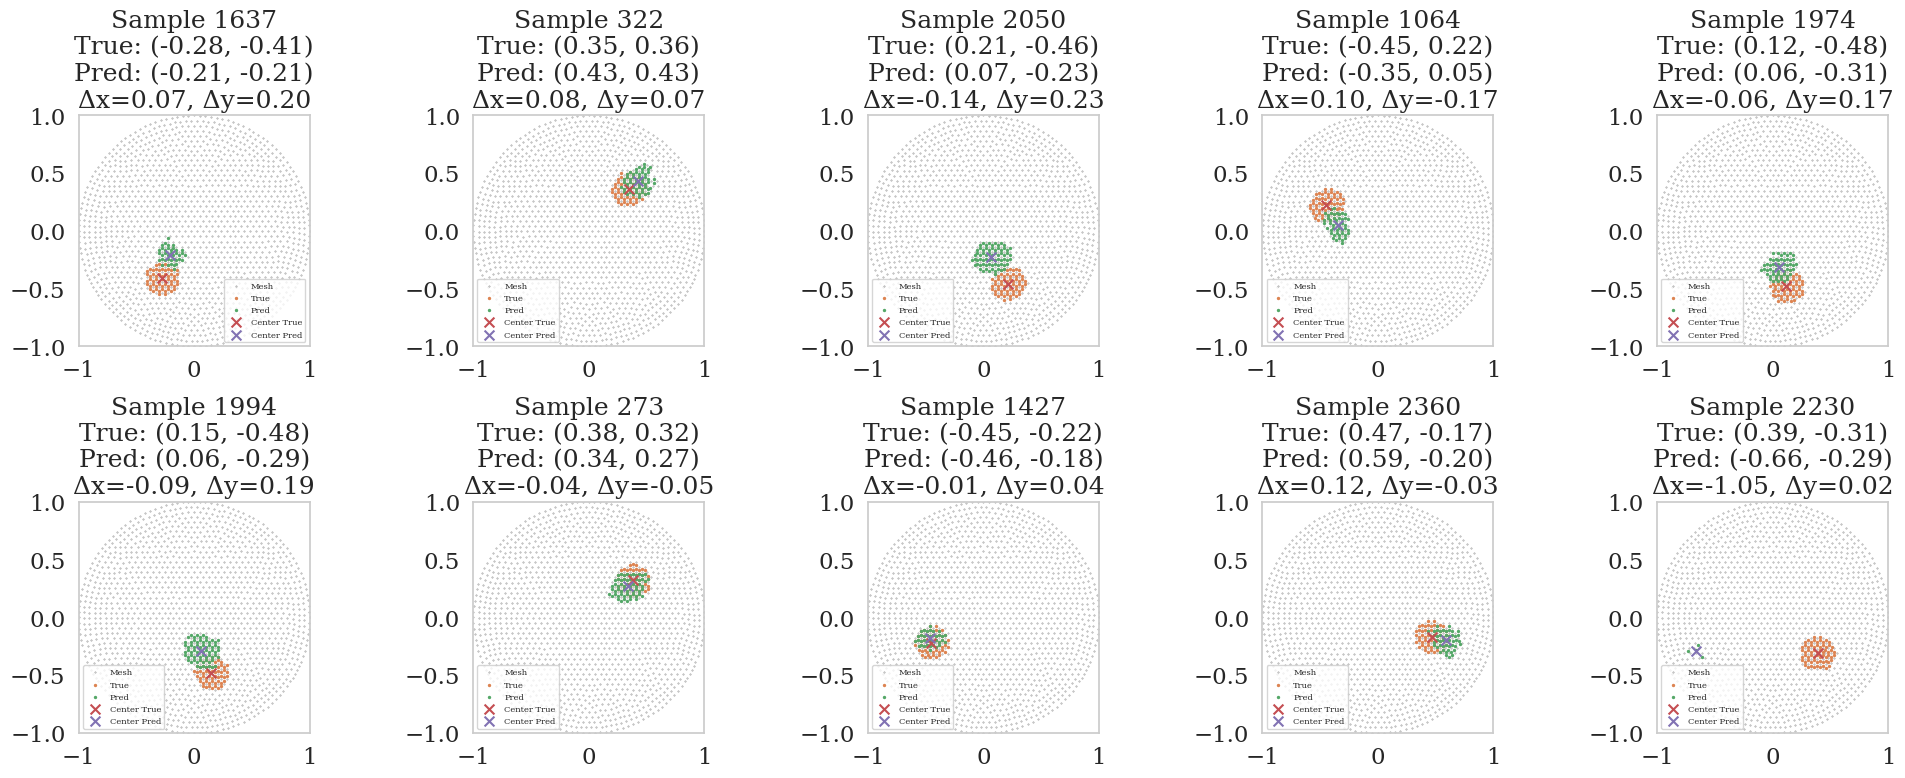

In [36]:
plot_random_deviations(mesh_obj, gamma_test, gamma_pred, num_samples=10, threshhold=0.5)

In [34]:
def evaluation_of_precision(gamma_true, gamma_pred, plot=True):
    """Calculates deviation of perm center and reconstructed perm space

    Returns:
    --------
    tuple or None
        Returns (delta_x, delta_y, delta_perm) if calculation successful,
        None if invalid data encountered
    """
    pts = mesh_obj.element
    tri = mesh_obj.node
    tri_centers = np.mean(tri[pts], axis=1)
    perm_min = 0.5 

    # Get indices and check if any were found
    indices1 = np.where(gamma_true > perm_min)[0]
    indices2 = np.where(gamma_pred > perm_min)[0]
    
    # Check if either array is empty
    if len(indices1) == 0 or len(indices2) == 0:
        if plot:
            print("Warning: No elements found above threshold in either true or predicted data")
        return None
    
    # Calculate coordinates and means
    coords1 = tri_centers[indices1]
    coords2 = tri_centers[indices2]
    
    # Calculate means with error checking
    x1 = np.mean(coords1[:, 0])
    y1 = np.mean(coords1[:, 1])
    x2 = np.mean(coords2[:, 0])
    y2 = np.mean(coords2[:, 1])
    
    # Check for NaN values
    if np.isnan([x1, y1, x2, y2]).any():
        if plot:
            print("Warning: NaN values encountered in coordinate calculations")
        return None
    
    # Round values after checking for NaN
    x1 = round(x1, 3)
    y1 = round(y1, 3)
    x2 = round(x2, 3)
    y2 = round(y2, 3)

    delta_x = x1 - x2
    delta_y = y1 - y2
    delta_perm = len(coords1) - len(coords2)

    if plot:
        print(f'Ground Truth Center: x={x1}, y={y1}')
        print(f'Reconstructed Center: x={x2}, y={y2}')
        print(f"Δx: {delta_x}, Δy: {delta_y}")
        print(f"ΔPerm: {delta_perm}")

        plt.figure(figsize=(5, 5))
        plt.grid()
        plt.xlim((-1.1, 1.1))
        plt.ylim((-1.1, 1.1))
        plt.scatter(tri_centers[:, 0], tri_centers[:, 1], label='Mesh Centers', alpha=0.4, s=10)
        plt.scatter(coords1[:, 0], coords1[:, 1], color='green', label='Ground Truth')
        plt.scatter(coords2[:, 0], coords2[:, 1], color='orange', label='Reconstruction')
        plt.scatter(x1, y1, marker='x', color='blue', s=50, label='Ground Truth Center')
        plt.scatter(x2, y2, color='red', s=50, label='Reconstructed Center')
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

    return delta_x, delta_y, delta_perm


def plot_position_deviations(deviations_data, save_path=None, figsize=(8, 8), limits=(-1, 1), kde_levels=50, colormap='viridis',
                        font_scale=1.5):
    try:
        # Data preparation
        df = pd.DataFrame({
            'x-Abweichung': np.asarray(deviations_data['x-Abweichung']).flatten(),
            'y-Abweichung': np.asarray(deviations_data['y-Abweichung']).flatten()
        })
        
        # Style settings
        plt.rcParams.update({'font.family': 'Serif'})
        sns.set(font_scale=font_scale, font='Serif', style='whitegrid')
        
        # Create joint plot
        g = sns.jointplot(
            data=df,
            x='x-Abweichung',
            y='y-Abweichung',
            kind='kde',
            xlim=limits,
            ylim=limits,
            height=figsize[0]
        )
        
        # Enhance the plot
        g.plot_joint(sns.kdeplot, fill=True, levels=kde_levels, cmap=colormap)
        
        # Add mean lines
        x_mean = np.mean(deviations_data['x-Abweichung'])
        y_mean = np.mean(deviations_data['y-Abweichung'])
        g.ax_joint.axvline(x=x_mean, color='r', linestyle='--', alpha=0.5)
        g.ax_joint.axhline(y=y_mean, color='r', linestyle='--', alpha=0.5)
        
        # Add statistics
        stats_text = (f"μx = {x_mean:.3f}\n"
                     f"μy = {y_mean:.3f}\n"
                     f"σx = {np.std(deviations_data['x-Abweichung']):.3f}\n"
                     f"σy = {np.std(deviations_data['y-Abweichung']):.3f}")
        g.ax_joint.text(0.02, 0.98, stats_text,
                       transform=g.ax_joint.transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Save if requested
        if save_path:
            plt.tight_layout()
            g.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")
            
        return g
        
    except Exception as e:
        print(f"Error in plotting position deviations: {str(e)}")
        raise

def plot_permittivity_deviation(perm_data, fe_elements=2840, save_path=None, figsize=(8, 6), bin_width=10, color='blue',
                              font_scale=1.5):
    
    try:
        # Style settings
        plt.rcParams.update({'font.family': 'Serif'})
        sns.set(font_scale=font_scale, font='Serif', style='whitegrid')
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot histogram with KDE
        sns.histplot(data=perm_data['Perm'], 
                    binwidth=bin_width, 
                    kde=True,
                    color=color,
                    alpha=0.6,
                    ax=ax)
        
        # Calculate statistics
        mean_dev = np.mean(perm_data['Perm'])
        std_dev = np.std(perm_data['Perm'])
        percent_dev = (mean_dev/fe_elements) * 100
        
        # Add statistics text box
        stats_text = (f"Mittlere Abweichung: {mean_dev:.1f} FE\n"
                     f"Standardabweichung: {std_dev:.1f} FE\n"
                     f"Prozentuale Abweichung: {percent_dev:.2f}%")
        ax.text(0.98, 0.98, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Labels and title
        ax.set_xlabel("Abweichende Elemente")
        ax.set_ylabel("Anzahl")
        ax.set_title("Verteilung der Permittivitätsabweichungen")
        
        # Save if requested
        if save_path:
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {save_path}")
            
        return fig
        
    except Exception as e:
        print(f"Error in plotting permittivity deviation: {str(e)}")
        raise

Plot saved to: Abbildungen/position_sim_reconstruct_deviations.pdf
Plot saved to: Abbildungen/perm_sim_reconstruct_deviations.pdf


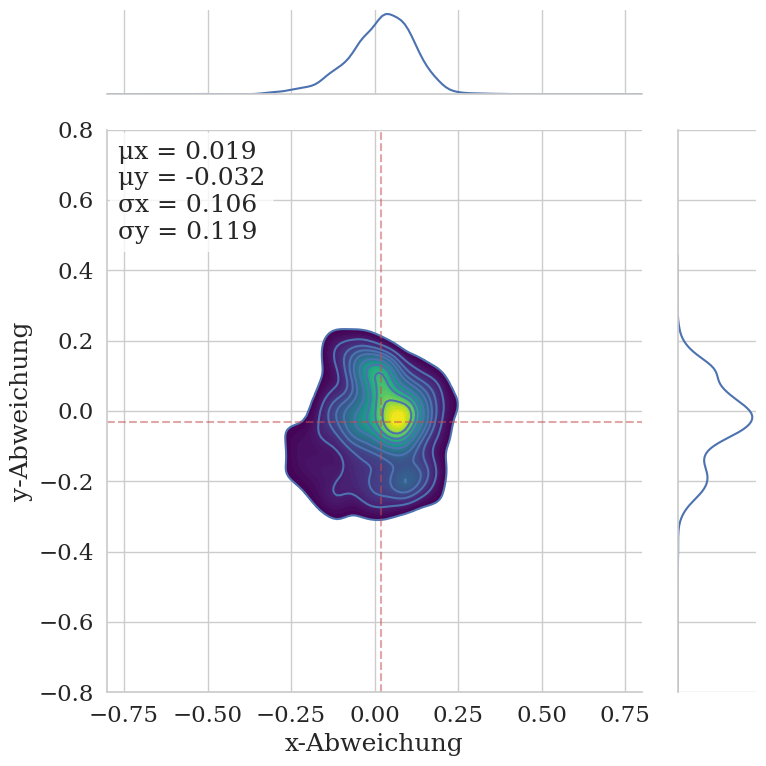

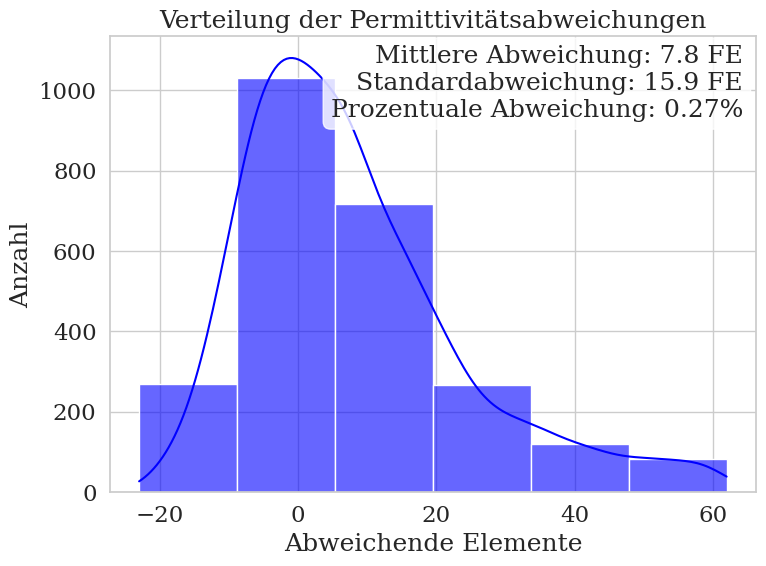

In [35]:

deviations_dict = {'x-Abweichung': [], 'y-Abweichung': []}
perm_dict = {'Perm': []}

for gt, pred in zip(gamma_test, gamma_pred):
    result = evaluation_of_precision(gt, pred, plot=False)
    if result is not None:  # Nur gültige Ergebnisse verwenden
        delta_x, delta_y, delta_perm = result
        deviations_dict['x-Abweichung'].append(delta_x)
        deviations_dict['y-Abweichung'].append(delta_y)
        perm_dict['Perm'].append(delta_perm)

g = plot_position_deviations(deviations_dict, 
                           save_path='Abbildungen/position_sim_reconstruct_deviations.pdf',
                           limits=(-0.8, 0.8))

fig = plot_permittivity_deviation(perm_dict,
                                save_path='Abbildungen/perm_sim_reconstruct_deviations.pdf',
                                bin_width=15)

#red dottet linie in der Arbeit erähnen und erklären

In [ ]:
#FE - Finite Elemente (Elemente)